In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Imports:
Just a few imports. Python 3.7 libraries.

In [2]:
# data science core
import pandas as pd
import numpy as np

#plotting data
import matplotlib.pyplot as plt
%matplotlib inline

# datetime management
import datetime

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# getting data
import requests

# technical analysis indicators
import talib  # financial indicators the easy way

### Get the public data from Binance API
This parameters are for the Bitcoin USDTheter pair. The candles are 4 hour sampled, just for getting time to react if the prediction is a good one, because we will try to predict the closing price for the next candle.

In [3]:
market = 'BTCUSDT'
tick_interval = '1d'
limit = 1000  #1000 binance API max of candles to get

### Select an algo.... 
I love Random Forest algo

In [4]:
forest_depth = 250  # more depth... more precssision?
model = RandomForestRegressor(forest_depth)

### Altcoins adjustment
Just if you want to play with other pairs, this adjustment will make you get different results. I know data, theoretically, with random forest algo, doesn't need to be normalized, but altcoins with a value with many decimals will outperform. Just play with it.

In [5]:
# altcoins adjustment
#alt_adjust = 1000000  # cardanobtc
#alt_adjust = 10000  # vetbtc
alt_adjust = 1 # btcusdt

### API call:

In [6]:
url_prices = 'https://api.binance.com/api/v1/klines?symbol='+market+'&interval='+tick_interval+'&limit='+str(limit)
init_candles = requests.get(url_prices).json()

### Settings:

-prediction_candles: Candles to plot for... but... not really the prediction.... we'll see...

-time_window: Time series usually get the previous path of price each candle, the algo will use the paths to learn possibly patterns

-shift_val: This is the really prediction interval. One means one candle forward. This code really just predict next candle price, but... you can pley with this!

In [7]:
prediction_candles = 50
time_window = 7
shift_val = 1

### Build the dataframe:
Name the columns, drop the ignore column and set types.

In [8]:
df = pd.DataFrame(columns=['open_time','open', 'high', 'low','close','volume','close_time','quote','trades','takers_buy_base','takers_buy_quote','ignore'])
for i in range(len(init_candles)):
    df.loc[i] = init_candles[i]
df=df.drop(['ignore'],axis=1)
df = df.astype(float)

### The basic dataset:

In [9]:
# altcoin adjust
df[['open_time','open', 'high', 'low','close']] = df[['open_time','open', 'high', 'low','close']]*alt_adjust
df.tail(5)

,open_time,open,high,low,close,volume,close_time,quote,trades,takers_buy_base,takers_buy_quote
995,1.589155e+12,8722.77,9168.00,8200.00,8561.52,168807.251832,1.589242e+12,1.468393e+09,1367382.0,81474.595067,7.089589e+08
996,1.589242e+12,8562.04,8978.26,8528.78,8810.79,86522.780066,1.589328e+12,7.601955e+08,784859.0,40570.317401,3.565080e+08
997,1.589328e+12,8810.99,9398.00,8792.99,9309.37,92466.274018,1.589414e+12,8.397257e+08,869216.0,43648.354655,3.967140e+08
998,1.589414e+12,9309.35,9939.00,9256.76,9791.98,129565.377470,1.589501e+12,1.247457e+09,1199530.0,63438.510993,6.113139e+08
999,1.589501e+12,9791.97,9845.62,9256.12,9470.46,77974.833280,1.589587e+12,7.447876e+08,703171.0,37291.179084,3.563077e+08


In [10]:
df = df.drop(999)

### Indicators
Add RSI financial indicator and simple moving averages for seven and twenty one candles. Hope algo will learn something from it.

In [11]:
df['RSI'] = talib.RSI(df['close'],14)
df['MA_21'] = talib.MA(df['close'], 21)
df['MA_7'] = talib.MA(df['close'], 7)
#df["upperband"], df["middleband"], df["lowerband"] = talib.BBANDS(df['close'], timeperiod=prediction_candles, nbdevup=2, nbdevdn=2,matype=0)

### Build time series index:

In [12]:
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_time'] = df['close_time'].dt.tz_localize('utc').dt.tz_convert('Europe/Madrid')
df = df.set_index('close_time')

In [13]:
df.tail(3)

,open_time,open,high,low,close,volume,quote,trades,takers_buy_base,takers_buy_quote,RSI,MA_21,MA_7
close_time,,,,,,,,,,,,,
2020-05-13 01:59:59.999000+02:00,1.589242e+12,8562.04,8978.26,8528.78,8810.79,86522.780066,7.601955e+08,784859.0,40570.317401,3.565080e+08,56.033705,8543.201905,9223.401429
2020-05-14 01:59:59.999000+02:00,1.589328e+12,8810.99,9398.00,8792.99,9309.37,92466.274018,8.397257e+08,869216.0,43648.354655,3.967140e+08,61.581579,8647.212857,9247.180000
2020-05-15 01:59:59.999000+02:00,1.589414e+12,9309.35,9939.00,9256.76,9791.98,129565.377470,1.247457e+09,1199530.0,63438.510993,6.113139e+08,66.047624,8757.193333,9219.405714


### Binande API gives you the current candle closing time. 
The algo will predict closing price at that point

In [14]:
next_close_since_data = df[-1:].index
next_close_since_data[0]

Timestamp('2020-05-15 01:59:59.999000+0200', tz='Europe/Madrid')

### Some clean up for last line
Last line is not real in binance API, because it is not closed yet

In [15]:
# unfake last close
df.iloc[-1:,:]['close'] = np.nan
df.dropna(inplace=True) # last line is not real in binance because it is not closed yet

C:\Users\ffad\data_science\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Future values for each row
Now will add the future value for each candle... like it is some kind of product from the current data or at least I'm trying to predict patterns this way.
Pay attention to the negative value in the shift_val variable. Neggative shift means future value, but brought to each candle.

In [16]:
df['next_close'] = df['close'].shift(-shift_val)  # negative value... this is very important, negative means future value

df = df[['open', 'high', 'low','close','volume', 'RSI', 'MA_21', 'MA_7', 'next_close']]

#df = df[['open', 'high', 'low','close','volume', 'RSI', 'MA_21', 'MA_7', 'next_close', 'upperband', 'middleband', 'lowerband']]

### Check the dataset:
Last row has no future shifted value, it's not closed yet!


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 978 entries, 2017-09-10 01:59:59.999000+02:00 to 2020-05-14 01:59:59.999000+02:00
Data columns (total 9 columns):
open          978 non-null float64
high          978 non-null float64
low           978 non-null float64
close         978 non-null float64
volume        978 non-null float64
RSI           978 non-null float64
MA_21         978 non-null float64
MA_7          978 non-null float64
next_close    977 non-null float64
dtypes: float64(9)
memory usage: 76.4 KB


In [18]:
df.tail(5)

,open,high,low,close,volume,RSI,MA_21,MA_7,next_close
close_time,,,,,,,,,
2020-05-10 01:59:59.999000+02:00,9800.02,9914.25,9520.00,9539.40,81950.679567,70.138873,8290.528571,9322.382857,8722.77
2020-05-11 01:59:59.999000+02:00,9539.10,9574.83,8117.00,8722.77,183865.182028,55.259592,8366.815714,9297.898571,8561.52
2020-05-12 01:59:59.999000+02:00,8722.77,9168.00,8200.00,8561.52,168807.251832,52.874377,8449.420000,9253.550000,8810.79
2020-05-13 01:59:59.999000+02:00,8562.04,8978.26,8528.78,8810.79,86522.780066,56.033705,8543.201905,9223.401429,9309.37
2020-05-14 01:59:59.999000+02:00,8810.99,9398.00,8792.99,9309.37,92466.274018,61.581579,8647.212857,9247.180000,NaN


### A function: plot the data

In [19]:
def plotting(df, width=0.1):
    
    fig = plt.figure()
    fig.set_size_inches((20, 8))  # figure size
    
    # sub-figures relative positions
    ax_candle = fig.add_axes((0, 0.2, 1, 1))
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # x axis as date
    ax_candle.xaxis_date()
    
    # close prices
    ax_candle.plot(df['close'])
    
    # volume
    ax_vol.bar(df.index, df["volume"] / 1000, width=width)   
    ax_vol.set_ylabel("BTC * 1000")  # just for intuitive view
    
    # title and plot
    ax_candle.set_title(market)
    plt.grid()
    plt.show()
    return

C:\Users\ffad\data_science\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


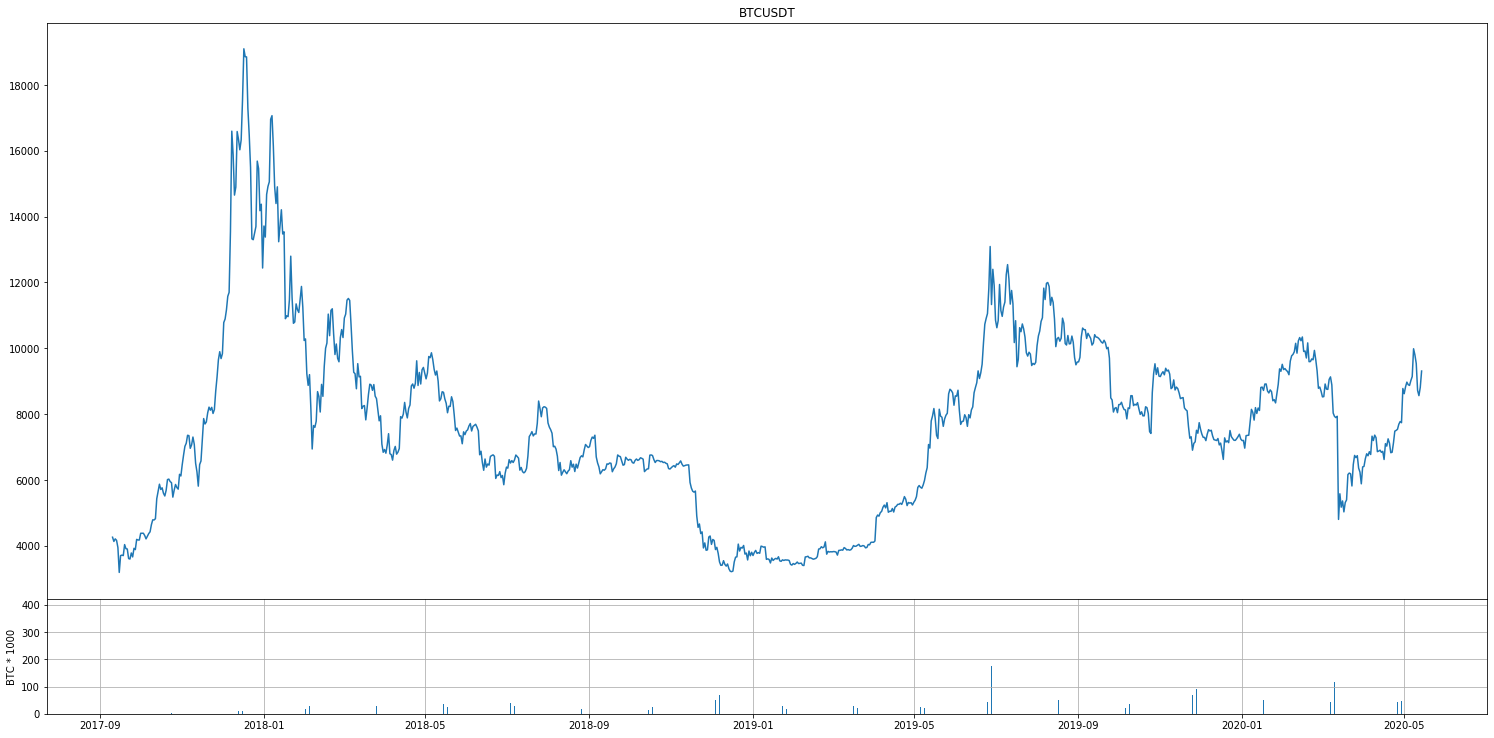

In [20]:
plotting(df, width=0.025)

### Another plot with indicators

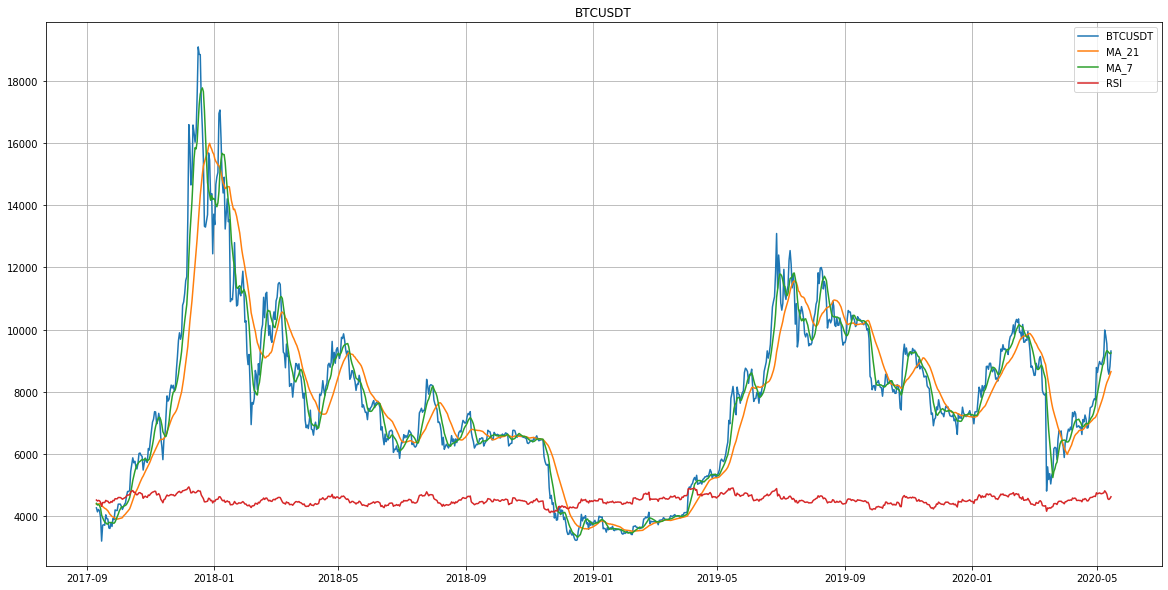

In [21]:
fid, axe = plt.subplots(figsize=(20,10))
axe.plot(df.index, df['close'], label=market)
axe.plot(df.index, df['MA_21'], label='MA_21')
axe.plot(df.index, df['MA_7'], label='MA_7')
axe.plot(df.index, df['RSI']*10+4000, label='RSI')  # adjusted for better view
plt.title(market)
plt.legend()
plt.grid()
plt.show()

### Add price path each candle:
Let's put into each candle the path prices do into the time window defined.

In [22]:
def create_time_window(df, time_window):
    df_cols = df.columns
    for i in range(1,time_window): # for time_window days, this was set before
        for col in df_cols:
            df[f'{col}_'+str(i)] = df[col].shift(i)
    return df

historical_df = create_time_window(df, time_window)    

### Put appart last line for prediction:

In [23]:
test_last_closed_line=historical_df.iloc[-1:,:]  # last line for predciting

In [24]:
test_last_closed_line

,open,high,low,close,volume,RSI,MA_21,MA_7,next_close,open_1,...,next_close_5,open_6,high_6,low_6,close_6,volume_6,RSI_6,MA_21_6,MA_7_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,
2020-05-14 01:59:59.999000+02:00,8810.99,9398.0,8792.99,9309.37,92466.274018,61.581579,8647.212857,9247.18,NaN,8562.04,...,9539.4,9143.4,10067.0,9021.0,9986.4,147154.611378,80.878044,8049.420952,9102.325714,9800.01


### We keep NaN value in the last closed candle:
Candle was closed but the next close candle is in each one, and it's not a number becaus it is not closed yet

In [25]:
historical_df.tail(3)

,open,high,low,close,volume,RSI,MA_21,MA_7,next_close,open_1,...,next_close_5,open_6,high_6,low_6,close_6,volume_6,RSI_6,MA_21_6,MA_7_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,
2020-05-12 01:59:59.999000+02:00,8722.77,9168.00,8200.00,8561.52,168807.251832,52.874377,8449.420000,9253.550000,8810.79,9539.10,...,9986.40,8871.92,9118.58,8760.00,9021.83,76480.765342,73.029792,7791.985714,8855.075714,9142.92
2020-05-13 01:59:59.999000+02:00,8562.04,8978.26,8528.78,8810.79,86522.780066,56.033705,8543.201905,9223.401429,9309.37,8722.77,...,9800.01,9021.36,9395.00,8906.21,9142.92,105925.302420,74.271875,7912.065714,8907.125714,9986.40
2020-05-14 01:59:59.999000+02:00,8810.99,9398.00,8792.99,9309.37,92466.274018,61.581579,8647.212857,9247.180000,NaN,8562.04,...,9539.40,9143.40,10067.00,9021.00,9986.40,147154.611378,80.878044,8049.420952,9102.325714,9800.01


### Let's delete the last row:
Because we are trying to predict the next candle close price for that row and we keep appart that row into a variable

In [26]:
historical_df.dropna(inplace=True)  # delete missing RSI, MA and last line because NaN in next_close

In [27]:
historical_df.tail(3)

,open,high,low,close,volume,RSI,MA_21,MA_7,next_close,open_1,...,next_close_5,open_6,high_6,low_6,close_6,volume_6,RSI_6,MA_21_6,MA_7_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,
2020-05-11 01:59:59.999000+02:00,9539.10,9574.83,8117.00,8722.77,183865.182028,55.259592,8366.815714,9297.898571,8561.52,9800.02,...,9142.92,8894.15,8950.00,8522.00,8871.96,84418.512331,71.445487,7689.455714,8671.811429,9021.83
2020-05-12 01:59:59.999000+02:00,8722.77,9168.00,8200.00,8561.52,168807.251832,52.874377,8449.420000,9253.550000,8810.79,9539.10,...,9986.40,8871.92,9118.58,8760.00,9021.83,76480.765342,73.029792,7791.985714,8855.075714,9142.92
2020-05-13 01:59:59.999000+02:00,8562.04,8978.26,8528.78,8810.79,86522.780066,56.033705,8543.201905,9223.401429,9309.37,8722.77,...,9800.01,9021.36,9395.00,8906.21,9142.92,105925.302420,74.271875,7912.065714,8907.125714,9986.40


### We got the last closed line in the freezer
The next_close columns will be the closing predicted price for the current candle

In [28]:
test_last_closed_line

,open,high,low,close,volume,RSI,MA_21,MA_7,next_close,open_1,...,next_close_5,open_6,high_6,low_6,close_6,volume_6,RSI_6,MA_21_6,MA_7_6,next_close_6
close_time,,,,,,,,,,,,,,,,,,,,,
2020-05-14 01:59:59.999000+02:00,8810.99,9398.0,8792.99,9309.37,92466.274018,61.581579,8647.212857,9247.18,NaN,8562.04,...,9539.4,9143.4,10067.0,9021.0,9986.4,147154.611378,80.878044,8049.420952,9102.325714,9800.01


### Now build the machine learning model without the data to predict, the closing price
But... are we cheating?!?!... because we get the future closing price into each row.... yes.. but we got nothing in the last closed candle row, was put appart... to avoid cheating!!!

In [29]:
X_train = historical_df.iloc[:-prediction_candles,:].drop('close', axis=1)
X_test = historical_df.iloc[-prediction_candles:,:].drop('close', axis=1)
y_train = historical_df.iloc[:-prediction_candles,:]['close'].values
y_test = historical_df.iloc[-prediction_candles:,:]['close'].values

# Predicting

### RandomForestRegressor:
This will take a little while training the model

In [30]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Let's build a dataframe with results to plot it

In [31]:
result_df = pd.DataFrame()
result_df['real_next_close'] = y_test
result_df['pred_next_close'] = pred

result_df['error'] = result_df['real_next_close'] - result_df['pred_next_close']  # dollars error each prediction
result_df['error_percent'] = (result_df['error']/result_df['real_next_close'])*100  # percent error each prediction

result_df['time'] = historical_df.iloc[-prediction_candles:,:].index
result_df = result_df.set_index('time')


### Check results:
How many dollars of error each candle predicted?

In [32]:
result_df['error'].abs().mean()  # error in dollars mean

7.3728727999987855

In [33]:
result_df['error_percent'].abs().mean()  # percent error mean

0.09583004270001487

### Results seems a low percent value:
Plot the results comparing real next close with predicted

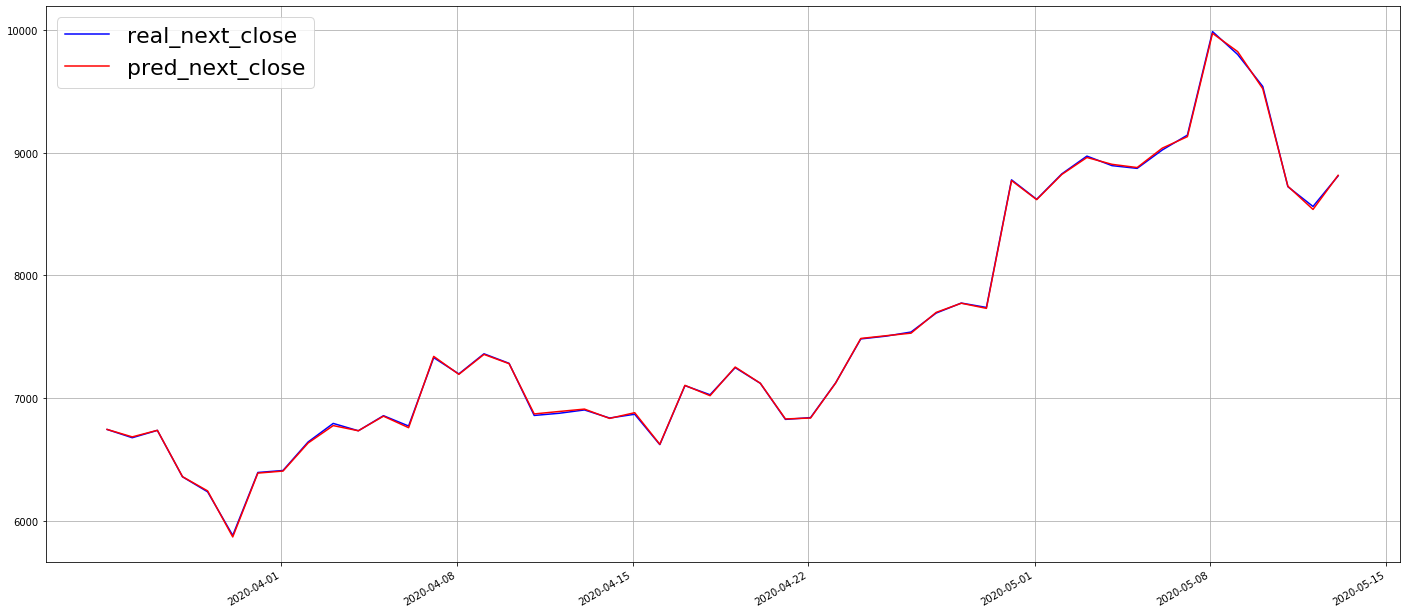

In [34]:
fig, axe = plt.subplots(figsize=(20,9))

axe.plot(result_df.index, result_df['real_next_close'], color = 'blue', label = 'real_next_close')
axe.plot(result_df.index, result_df['pred_next_close'], color = 'red', label = 'pred_next_close')

plt.rcParams.update({'font.size': 22})

fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

### It seems a nice plot, but.... 
Algo predicted just the next row closing price each one. That's because we used data next to the candle before the last closed one. That is not too much prediction time window.

### But... exchanges charge a fee.... in example 1%
If binance charges a fee of 1% when and order wass filled and other 1% to get out, then, check the oportunity window.

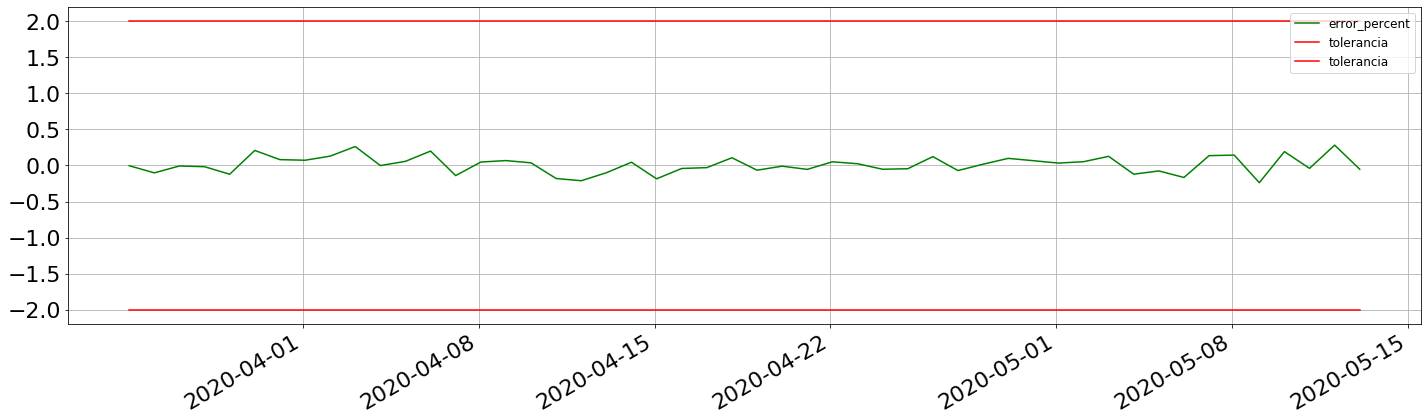

In [35]:
fig, axe = plt.subplots(figsize=(20,6))

result_df['tolerancia+'] = 2
result_df['tolerancia-'] = -2

axe.plot(result_df.index, result_df['error_percent'], color = 'green', label = 'error_percent')

axe.plot(result_df.index[-prediction_candles:], result_df.iloc[-prediction_candles:]['tolerancia+'], color = 'red', label = 'tolerancia')
axe.plot(result_df.index[-prediction_candles:], result_df.iloc[-prediction_candles:]['tolerancia-'], color = 'red', label = 'tolerancia')

plt.rcParams.update({'font.size': 12})

fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

## Predicting next hop:
OK this data seems working out... really?... let's predict and see

In [36]:
test_last_closed_line = test_last_closed_line.drop(['next_close'], axis=1)
pred_future = model.predict(test_last_closed_line)

In [37]:
pred_future  # next closing price prediction

array([9309.29544])

In [38]:
'%f' % (pred_future/alt_adjust) # predicted price

'9309.295440'

### Keep in mind that the next_close column will predict at the next tick interval from this one
If you choose 4h tick_interval... then timedelta is hours=4. Remember to change it manually

In [39]:
time = test_last_closed_line.index[0]
delta = datetime.timedelta(days=1)  # WARNING!!!! this settings are for 4 h tick interval. You need to use your tick interval
time+delta

Timestamp('2020-05-15 01:59:59.999000+0200', tz='Europe/Madrid')

## Is it an opportuniy?
Well, get the current price and compare with the prediction

In [40]:
url_current_price = 'https://api.binance.com/api/v3/ticker/price?symbol=' + market
current_price = float(requests.get(url_current_price).json()['price'])

In [41]:
current_price*alt_adjust, pred_future

(9480.46, array([9309.29544]))

### But if you check the fees... maybe not all that glitters is gold

In [42]:
percent = (pred_future/(current_price*alt_adjust))*100-100 # oportunidad sin comisiones al precio actual

In [43]:
percent[0]  #percent change at next_close

-1.8054457273170499

### How much money would you lose paying fees if you trade one BTC?

In [44]:
calc = percent[0] - 2
calc

-3.80544572731705

In [45]:
current_price * alt_adjust * (calc/100)

-360.77376000000197

### Well.. that's all for now!!!

I kept studying

# Thank You!